In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
#%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
#from sklearn.manifold import TSNE
#from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
#from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
#import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

from tqdm import tqdm
import time
from sklearn import preprocessing
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import torch
from torch import nn, optim
import torch.nn.functional as F

# Загрузка датасета

In [2]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

In [3]:
data_path = './training.1600000.processed.noemoticon.csv'
df = pd.read_csv(data_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [4]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [6]:
df.head(10)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


## Предобработка

In [8]:
decode_map = {0: -1, 2: 0, 4: 1}
def decode_sentiment(label):
    return decode_map[int(label)]

In [9]:
df.target = df.target.apply(lambda x: decode_sentiment(x))

Text(0.5, 1.0, 'Dataset labels distribuition')

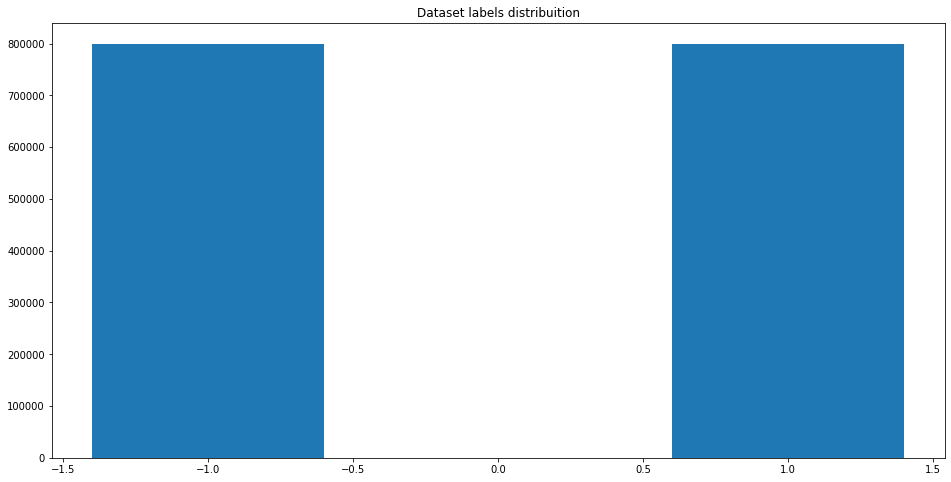

In [10]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

Удаляем ненужные столбцы и уменьшаем выборку потому что мы не хотим сидеть ждать неделю на каждом запуске

In [29]:
#data = df[:10000]
data = df.sample(frac=1)
data = data[:1000] 
data = data.drop(['ids', 'date', 'flag', 'user'], axis = 1)
data = data.reset_index(drop=True)
data

,target,text
0,-1,"Just got off the phone with the boyfrann, miss..."
1,1,watching neighbourssssss
2,1,"YES YES finaly the weekend is here, pity about..."
3,-1,"@RokkKrinn . and what a bloodbath if he does, ..."
4,1,@Hiltaldo Sounds perfect!! Enjoy
...,...,...
995,-1,Desperately tired with another late night to l...
996,1,Triclops custom Man-3-Faces now online http://...
997,-1,@courtrex I prefered the soviet union il refe...
998,1,Everybody vote MILEY for the MTV awards GO MI...


In [31]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dredpury/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
stopwords = stopwords.words('english')

AttributeError: 'list' object has no attribute 'words'

In [33]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [34]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/dredpury/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [35]:
def lemmatize_df(df, stopwords, column):
    lemmatizer = WordNetLemmatizer()
    for i in range(len(df[column])):
        temp_string = ""
        for word in df[column][i].split():
            word = ("".join(e for e in word if e.isalnum()))
            word = word.lower()
            word = lemmatizer.lemmatize(word)
            if not word in stopwords:
                temp_string += word + " "  
            
        df.at[i,column] = temp_string.strip()
    return df

In [36]:
lemmatized_data_tweets = lemmatize_df(data, stopwords, 'text')

In [37]:
lemmatized_data_tweets

,target,text
0,-1,got phone boyfrann missin bed time longgg day ...
1,1,watching neighbour
2,1,yes yes finaly weekend pity bad weather hey fi...
3,-1,rokkkrinn bloodbath doe kid quantum jazmin l...
4,1,hiltaldo sound perfect enjoy
...,...,...
995,-1,desperately tired another late night look forw...
996,1,triclops custom man3faces online httpbitly14yg...
997,-1,courtrex prefered soviet union il refer quotwe...
998,1,everybody vote miley mtv award go miley


In [38]:
tweets_copy = lemmatized_data_tweets.copy()
encoders = {}

encoder = preprocessing.LabelEncoder()
encoder.fit(tweets_copy["target"])
tweets_copy["target"] = encoder.transform(tweets_copy["target"])
encoders["target"] = encoder

In [39]:
df_train, df_test = train_test_split(data, test_size=1-0.8, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 800
TEST size: 200


In [40]:
data_split = tweets_copy.copy()
y = data_split['target'].values
x = data_split.drop(['target'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2)
vect = CountVectorizer(min_df=10)

In [41]:
X_train_review_bow = vect.fit_transform(list(X_train['text'])).toarray()
X_test_review_bow = vect.transform(X_test['text']).toarray()

In [42]:
def test_model(model, X_test, Y_test):
    counter = 0
    y_test_len = len(Y_test)

    with torch.no_grad():
        for i,data in enumerate(X_test):
            y_val = model.forward(data)
            if y_val.argmax().item() == Y_test[i]:
                counter += 1
    print(f'{counter} out of {y_test_len} = {100*counter/y_test_len:.2f}% right')

In [43]:
X_train = torch.Tensor(X_train_review_bow)
Y_train = torch.LongTensor(Y_train)
X_test = torch.Tensor(X_test_review_bow)
Y_test = torch.LongTensor(Y_test)

In [44]:
len_vector = X_train_review_bow.shape[1]
len_vector

85

# Модели
Модель 1

In [115]:
model = nn.Sequential(
        nn.Linear(len_vector, 10000),
        nn.Linear(10000, 1000),
        nn.Linear(1000, 100),
        nn.Linear(100, 10),
        nn.Sigmoid())


In [116]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [117]:
epochs = 10
results1 = []
potracheno = []
for i in range(epochs):
    i += 1
    Y_pred = model.forward(X_train)
    loss = criterion(Y_pred, Y_train)
    potracheno.append(loss)

    print(f'Эпоха:{i} потрачено:{loss.item():10.8f}')
    counter = 0
    y_test_len = len(Y_test)
    with torch.no_grad():
        for i,data in enumerate(X_test):
            y_val = model.forward(data)
            if y_val.argmax().item() == Y_test[i]:
                counter += 1
    model1_result = f'{100*counter/y_test_len:.2f}%'       
    print(f'{counter} из {y_test_len} = {model1_result} угадано')
    results1.append(100*counter/y_test_len)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Эпоха:1 потрачено:2.28530502
33 из 200 = 16.50% угадано
Эпоха:2 потрачено:1.59830356
107 из 200 = 53.50% угадано
Эпоха:3 потрачено:1.71692705
107 из 200 = 53.50% угадано
Эпоха:4 потрачено:1.59797990
107 из 200 = 53.50% угадано
Эпоха:5 потрачено:1.59797990
107 из 200 = 53.50% угадано
Эпоха:6 потрачено:1.59797990
107 из 200 = 53.50% угадано
Эпоха:7 потрачено:1.59797990
107 из 200 = 53.50% угадано
Эпоха:8 потрачено:1.59797990
107 из 200 = 53.50% угадано
Эпоха:9 потрачено:1.59797990
107 из 200 = 53.50% угадано
Эпоха:10 потрачено:1.59797990
107 из 200 = 53.50% угадано


In [118]:
counter = 0
y_test_len = len(Y_test)
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_val = model.forward(data)
        if y_val.argmax().item() == Y_test[i]:
            counter += 1
model1_result = f'{100*counter/y_test_len:.2f}%'       
print(f'{counter} из {y_test_len} = {model1_result} угадано')

107 из 200 = 53.50% угадано


Модель 2

In [119]:
model2 = nn.Sequential(
        nn.Linear(len_vector, 1488),
        nn.ReLU(),
        nn.Linear(1488, 69),
        nn.Sigmoid())

In [120]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)

In [121]:
epochs = 10
results2 = []
potracheno = []
for i in range(epochs):
    i += 1
    Y_pred = model2.forward(X_train)
    loss = criterion(Y_pred, Y_train)
    potracheno.append(loss)

    print(f'Эпоха:{i} потрачено:{loss.item():10.8f}')
    counter = 0
    y_test_len = len(Y_test)
    with torch.no_grad():
        for i,data in enumerate(X_test):
            y_val = model2.forward(data)
            if y_val.argmax().item() == Y_test[i]:
                counter += 1
    model2_result = f'{100*counter/y_test_len:.2f}%'       
    print(f'{counter} из {y_test_len} = {model2_result} угадано')
    results2.append(100*counter/y_test_len)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Эпоха:1 потрачено:4.22667170
16 из 200 = 8.00% угадано
Эпоха:2 потрачено:3.86249113
107 из 200 = 53.50% угадано
Эпоха:3 потрачено:3.56585121
112 из 200 = 56.00% угадано
Эпоха:4 потрачено:3.39585853
118 из 200 = 59.00% угадано
Эпоха:5 потрачено:3.32581997
119 из 200 = 59.50% угадано
Эпоха:6 потрачено:3.29950166
122 из 200 = 61.00% угадано
Эпоха:7 потрачено:3.28943944
120 из 200 = 60.00% угадано
Эпоха:8 потрачено:3.28548288
123 из 200 = 61.50% угадано
Эпоха:9 потрачено:3.28389096
125 из 200 = 62.50% угадано
Эпоха:10 потрачено:3.28323126
132 из 200 = 66.00% угадано


In [122]:
counter = 0
y_test_len = len(Y_test)
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_val = model2.forward(data)
        if y_val.argmax().item() == Y_test[i]:
            counter += 1
model2_result = f'{100*counter/y_test_len:.2f}%'       
print(f'{counter} из {y_test_len} = {model2_result} угадано')

130 из 200 = 65.00% угадано


Модель 3

In [123]:
model3 = nn.Sequential(
        nn.Linear(len_vector, 2624),
        nn.Linear(2624, 656),
        nn.Linear(656, 164),
        nn.Linear(164, 41),
        nn.Sigmoid())

In [124]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.01)
epochs = 10
potracheno = []
results3 = []
for i in range(epochs):
    i += 1
    Y_pred = model3.forward(X_train)
    loss = criterion(Y_pred, Y_train)
    potracheno.append(loss)

    print(f'Эпоха:{i} потрачено:{loss.item():10.8f}')
    counter = 0
    y_test_len = len(Y_test)
    with torch.no_grad():
        for i,data in enumerate(X_test):
            y_val = model2.forward(data)
            if y_val.argmax().item() == Y_test[i]:
                counter += 1
    model3_result = f'{100*counter/y_test_len:.2f}%'       
    print(f'{counter} из {y_test_len} = {model3_result} угадано')
    results3.append(100*counter/y_test_len)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Эпоха:1 потрачено:3.70059514
130 из 200 = 65.00% угадано
Эпоха:2 потрачено:3.16623211
130 из 200 = 65.00% угадано
Эпоха:3 потрачено:2.79406404
130 из 200 = 65.00% угадано
Эпоха:4 потрачено:2.79406309
130 из 200 = 65.00% угадано
Эпоха:5 потрачено:2.79406309
130 из 200 = 65.00% угадано
Эпоха:6 потрачено:2.79406309
130 из 200 = 65.00% угадано
Эпоха:7 потрачено:2.79406309
130 из 200 = 65.00% угадано
Эпоха:8 потрачено:2.79406309
130 из 200 = 65.00% угадано
Эпоха:9 потрачено:2.79406309
130 из 200 = 65.00% угадано
Эпоха:10 потрачено:2.79406309
130 из 200 = 65.00% угадано


In [125]:
counter = 0
y_test_len = len(Y_test)
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_val = model3.forward(data)
        if y_val.argmax().item() == Y_test[i]:
            counter += 1
model3_result = f'{100*counter/y_test_len:.2f}%'       
print(f'{counter} из {y_test_len} = {model3_result} угадано')

107 из 200 = 53.50% угадано


Модель 4

In [126]:
model4 = nn.Sequential(
        nn.Dropout(0.25),
        nn.Linear(len_vector, 500),
        nn.Linear(500, 28),
        nn.Sigmoid())

In [127]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=0.01)
epochs = 10
potracheno = []
results4 = []
for i in range(epochs):
    i += 1
    Y_pred = model4.forward(X_train)
    loss = criterion(Y_pred, Y_train)
    potracheno.append(loss)

    print(f'Эпоха:{i} потрачено:{loss.item():10.8f}')
    counter = 0
    y_test_len = len(Y_test)
    with torch.no_grad():
        for i,data in enumerate(X_test):
            y_val = model2.forward(data)
            if y_val.argmax().item() == Y_test[i]:
                counter += 1
    model4_result = f'{100*counter/y_test_len:.2f}%'       
    print(f'{counter} из {y_test_len} = {model4_result} угадано')
    results4.append(100*counter/y_test_len)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Эпоха:1 потрачено:3.31080604
130 из 200 = 65.00% угадано
Эпоха:2 потрачено:3.11916232
130 из 200 = 65.00% угадано
Эпоха:3 потрачено:2.91460347
130 из 200 = 65.00% угадано
Эпоха:4 потрачено:2.72645116
130 из 200 = 65.00% угадано
Эпоха:5 потрачено:2.59133220
130 из 200 = 65.00% угадано
Эпоха:6 потрачено:2.51996946
130 из 200 = 65.00% угадано
Эпоха:7 потрачено:2.48281002
130 из 200 = 65.00% угадано
Эпоха:8 потрачено:2.46555948
130 из 200 = 65.00% угадано
Эпоха:9 потрачено:2.45705438
130 из 200 = 65.00% угадано
Эпоха:10 потрачено:2.45288396
130 из 200 = 65.00% угадано


In [128]:
counter = 0
y_test_len = len(Y_test)
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_val = model4.forward(data)
        if y_val.argmax().item() == Y_test[i]:
            counter += 1
model4_result = f'{100*counter/y_test_len:.2f}%'       
print(f'{counter} из {y_test_len} = {model4_result} угадано')

118 из 200 = 59.00% угадано


In [129]:
print(f'Точность модели 1 {model1_result}')
print(f'Точность модели 2 {model2_result}')
print(f'Точность модели 3 {model3_result}')
print(f'Точность модели 4 {model4_result}')

Точность модели 1 53.50%
Точность модели 2 65.00%
Точность модели 3 53.50%
Точность модели 4 59.00%


In [130]:
Results1 = results1 + [np.nan for i in range(990)]
Results2 = results2 + [np.nan for i in range(990)]
Results3 = results3 + [np.nan for i in range(990)]
Results4 = results4 + [np.nan for i in range(990)]

plot = pd.DataFrame({
    'model1': Results1,
    'model2': Results2,
    'model3': Results3,
    'model4': Results4
})

<AxesSubplot:>

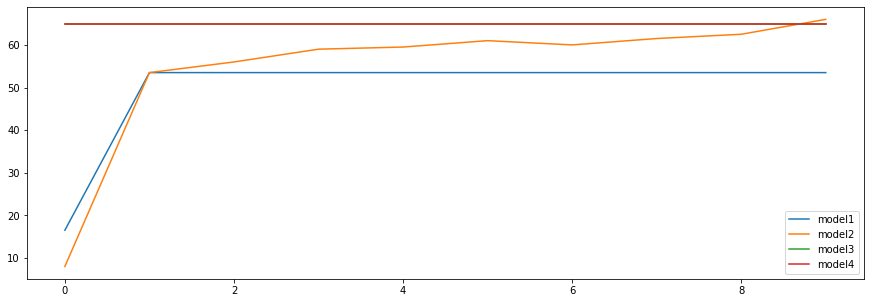

In [131]:
plot.plot(figsize=(15, 5))

Модель 2 имееет лучшую точность